In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
dt = 0.1
statesdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice_runtime")
savedir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice_runtime")
states = sorted(list(statesdir.glob("state.*")))
times = np.array([dt*i for i in range(len(states))])

In [3]:
state_, header_ = dns.readState(states[0])
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [5]:
projections_xu = np.zeros((len(states), ny_half-1), dtype=np.complex128)
projections_zu = np.zeros((len(states), ny_half), dtype=np.complex128)

projections_xv = np.zeros((len(states), ny_half-1), dtype=np.complex128)
projections_zv = np.zeros((len(states), ny_half-1), dtype=np.complex128)

projections_xw = np.zeros((len(states), ny_half), dtype=np.complex128)
projections_zw = np.zeros((len(states), ny_half-1), dtype=np.complex128)

In [6]:
for istate in range(len(states)):
    if istate % 100 == 0:
        print(istate, len(states))
    state, header = dns.readState(states[istate])
    forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt_, itime, time = header
    if Ry:
        # u component, only even modes
        # x template
        projections_xu[istate, :] = (state[1,1:,0,0] + np.conj(state[-1,1:,0,0]))/2
        # z template
        projections_zu[istate, :] = (state[0,:,1,0] + np.conj(state[0,:,-1,0]))/2
        
        # v component, only odd modes
        # x template
        projections_xv[istate, :] = -1j*(state[1,1:,0,1] - np.conj(state[-1,1:,0,1]))/2
        # z template
        projections_zv[istate, :] = -1j*(state[0,1:,1,1] - np.conj(state[0,1:,-1,1]))/2
        
        # w component, only even modes
        # x template
        projections_xw[istate, :] = (state[1,:,0,2] + np.conj(state[-1,:,0,2]))/2
        # z template
        projections_zw[istate, :] = (state[0,1:,1,2] + np.conj(state[0,1:,-1,2]))/2

0 1001
100 1001
200 1001
300 1001
400 1001
500 1001
600 1001
700 1001
800 1001
900 1001
1000 1001


In [7]:
projections_x = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)
projections_z = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)

projections_x[:,:ny_half-1] = projections_xu[:,:]
projections_x[:,ny_half-1:2*ny_half-2] = projections_xv[:,:]
projections_x[:,2*ny_half-2:] = projections_xw[:,:]

projections_z[:,:ny_half] = projections_zu[:,:]
projections_z[:,ny_half:2*ny_half-1] = projections_zv[:,:]
projections_z[:,2*ny_half-1:] = projections_zw[:,:]

In [8]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs, projs):
    res = np.einsum("ij,j",projs,coeffs,dtype=np.complex128)
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [9]:
def optimal_template(projections,str_projections,verbose=1,maxiter=1000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ncoeffs = projections.shape
    x0 = np.ones((ncoeffs))/np.sqrt(ncoeffs)
    
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    
    coeffs = opts.x
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if Ry:
        if str_projections == "x":
            template[1,1:,0,0] = coeffs[:ny_half-1] / 4
            template[-1,1:,0,0] = coeffs[:ny_half-1] / 4
            
            template[1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            template[-1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            
            template[1,:,0,2] = coeffs[2*ny_half-2:] / 4
            template[-1,:,0,2] = coeffs[2*ny_half-2:] / 4

        elif str_projections == "z":
            template[0,:,1,0] = coeffs[:ny_half] / 4
            template[0,:,-1,0] = coeffs[:ny_half] / 4

            template[0,1:,1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[0,1:,-1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[0,1:,1,2] = coeffs[2*ny_half-1:] / 4
            template[0,1:,-1,2] = coeffs[2*ny_half-1:]/ 4
    else:
        exit("Not yet implemented.")
    
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ij,j",projections,coeffs,dtype=np.complex128)
    abs_projections_opt = np.abs(projections_opt)
    shifts = find_shift(projections_opt)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phases
    fig, ax = plt.subplots()
    ax.plot(times, phases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\phi_{str_projections}$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"phase_{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

x
`gtol` termination condition is satisfied.
Number of iterations: 140, function evaluations: 6394, CG iterations: 248, optimality: 9.93e-09, constraint violation: 0.00e+00, execution time: 0.55 s.


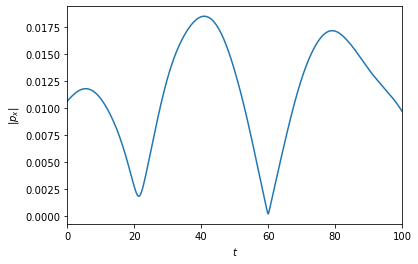

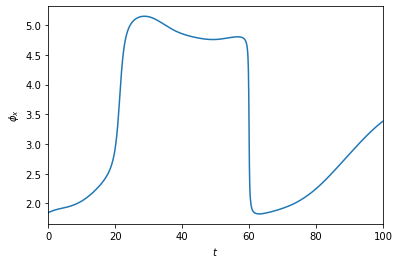

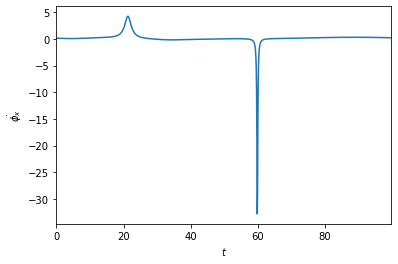

z
`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 644, CG iterations: 18, optimality: 2.21e-09, constraint violation: 2.72e-13, execution time: 0.054 s.


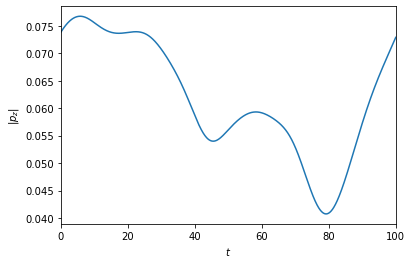

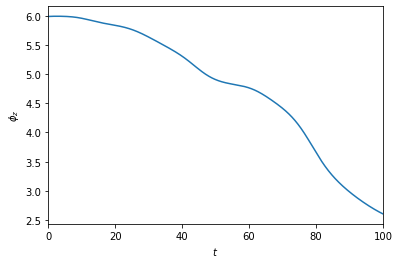

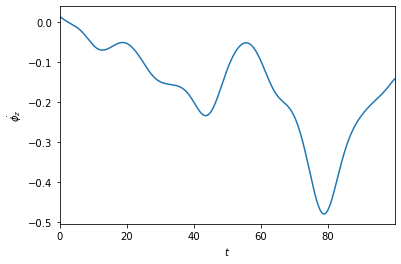

In [15]:
optimal_template(np.conjugate(projections_x),"x")
optimal_template(np.conjugate(projections_z),"z")

In [18]:
projdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice_runtime")

projections_x_runtime_rview = np.loadtxt(projdir / "slice_projections_x.gp")[:len(states),2:]
projections_z_runtime_rview = np.loadtxt(projdir / "slice_projections_z.gp")[:len(states),2:]

projections_x_runtime = projections_x_runtime_rview[:,::2] + 1j*projections_x_runtime_rview[:,1:][:,::2]
projections_z_runtime = projections_z_runtime_rview[:,::2] + 1j*projections_z_runtime_rview[:,1:][:,::2]

x


/home/gokhan/usr/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 138, function evaluations: 6302, CG iterations: 239, optimality: 8.49e-09, constraint violation: 0.00e+00, execution time: 0.53 s.


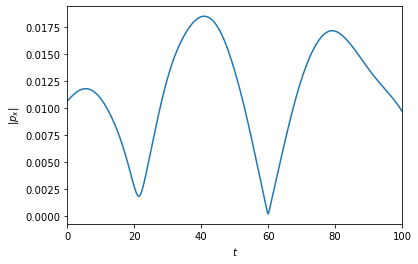

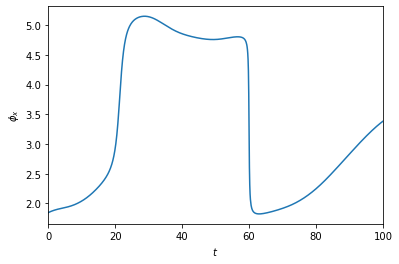

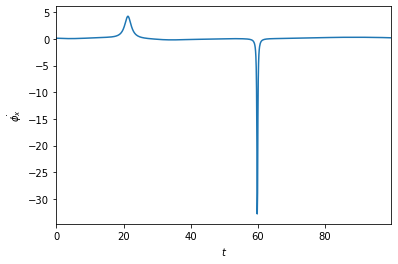

z
`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 644, CG iterations: 18, optimality: 2.21e-09, constraint violation: 2.72e-13, execution time: 0.053 s.


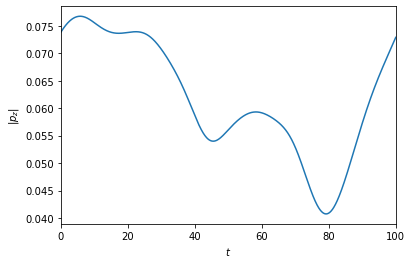

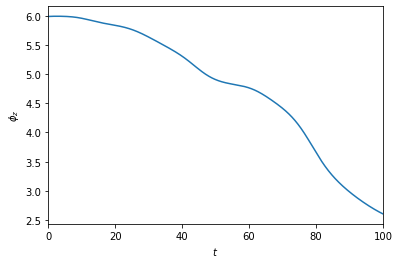

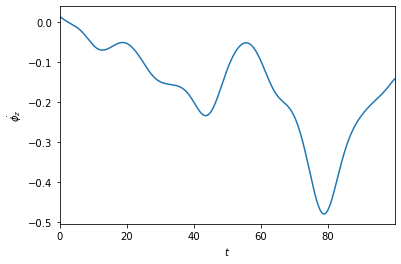

In [19]:
optimal_template(np.conjugate(projections_x_runtime),"x")
optimal_template(np.conjugate(projections_z_runtime),"z")

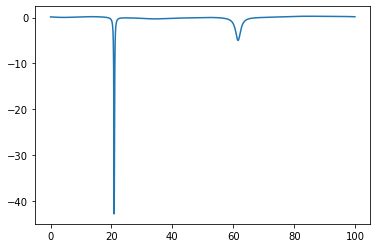

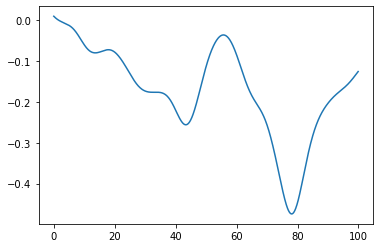

In [23]:
data = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice_runtime/phases.gp")
times_sim = data[:,1]
phases_x = np.unwrap(data[:,2])
phases_z = np.unwrap(data[:,3])
dt_sim = times_sim[1:] - times_sim[:-1]
dphix = (phases_x[1:] - phases_x[:-1])/dt
dphiz = (phases_z[1:] - phases_z[:-1])/dt

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphix)

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphiz)